# Navigation

---

For this project, you will train an agent to navigate (and collect bananas!) in a large, square world.

If running on the Udacity Workspace, the environment is already saved in the Workspace and can be accessed at the file path provided below. When running locally change the os variable (MACOS, LINUX, WINDOWS_32, WINDOWS_64) to match your OS

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import timeit

os = 'MACOS'
os_env = {
    'LINUX_X86': "./envs/⁨VisualBanana_Linux⁩/Banana.x86",
    'LINUX_X86_64': "./envs/⁨VisualBanana_Linux⁩/Banana.x86_64",
    'MACOS': "./envs/Banana.app",
    'WINDOWS_X86_32': "./envs/VisualBanana_Windows_x86/Banana.exe",
    'WINDOWS_X86_64': "./envs/VisualBanana_Windows_x86_64/Banana.exe",
}


print('Running on self built enviroment')
env = UnityEnvironment(file_name=os_env[os])

Running on self built enviroment


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Create a Memory Buffer

In [4]:
import numpy as np
from collections import namedtuple, deque

import random
import torch

import matplotlib.pyplot as plt
%matplotlib inline

class ReplayBuffer:
    '''Fixed-size buffer to store experience tuples.'''
    
    def __init__(self, device, action_size, buffer_size, batch_size, seed):
        '''Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        '''
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = device
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        
    def add(self, state, action, reward, next_state, done):
        '''Add a new experience to memory.'''
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        '''Randomly sample a batch of experiences from memory.'''
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        '''Return the current size of internal memory.'''
        return len(self.memory)

### 4. Training

Create a method that takes an agent and trains the model to solve the task.

In [5]:
def train(checkpoint_filename, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = [] # list to store scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start # initialize epsilon
    
    average_score = 0.0
    best_average_score = 0.0
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]         # send the action to the environment
            next_state = env_info.vector_observations[0]    # get the next state
            reward = env_info.rewards[0]                    # get the reward
            done = env_info.local_done[0]                   # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state                              # update the score
            score += reward
            if done:
                break
        
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        
        average_score = np.mean(scores_window)
        print(f'\rEpisode {i_episode}\tAverage Score: {average_score:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {average_score:.2f}')
            
        if average_score >= 13.0 and average_score > best_average_score:
            best_average_score = average_score
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)

    return scores

### 5. Setup for using Q Network

Setup variables and utility functions for using Q Network. `testWrapper` is a utility method for timing the training process.

In [6]:
import torch
from qnetwork.agent import Agent as QNetwork_Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def runQNetworkTest(checkpoint_filename, buffer_size, batch_size, seed, gamma, lr, update_every, tau, hidden_layer_lengths):
    memory = ReplayBuffer(device, action_size, buffer_size, batch_size, seed)
    agent = QNetwork_Agent(
        device, memory, action_size, state_size, seed,
        batch_size, gamma, lr, update_every, tau, hidden_layer_lengths
    )

    scores = train(checkpoint_filename, agent)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

def testWrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

#### 5.a Run using Buffer Size of 100,000

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 1.05
Episode 200	Average Score: 4.35
Episode 300	Average Score: 7.72
Episode 400	Average Score: 10.52
Episode 500	Average Score: 12.76
Episode 511	Average Score: 13.02
Environment solved in 511 episodes!	Average Score: 13.02
Episode 515	Average Score: 13.06
Environment solved in 515 episodes!	Average Score: 13.06
Episode 516	Average Score: 13.09
Environment solved in 516 episodes!	Average Score: 13.09
Episode 517	Average Score: 13.16
Environment solved in 517 episodes!	Average Score: 13.16
Episode 518	Average Score: 13.25
Environment solved in 518 episodes!	Average Score: 13.25
Episode 

Episode 1955	Average Score: 16.34
Environment solved in 1955 episodes!	Average Score: 16.34
Episode 1963	Average Score: 16.37
Environment solved in 1963 episodes!	Average Score: 16.37
Episode 2000	Average Score: 16.25


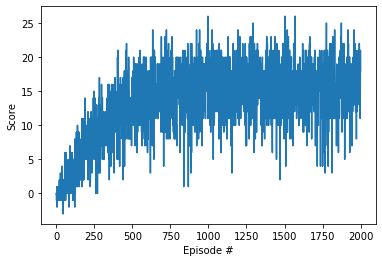

Time Taken: 1807.955898418004


In [8]:
# 64 Hidden Layers
SEED = 0
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

wrapped = testWrapper(runQNetworkTest, 'checkpoint-100000.pth', BUFFER_SIZE, BATCH_SIZE, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.b Run using Buffer Size of 200,000

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 1.75
Episode 200	Average Score: 4.69
Episode 300	Average Score: 7.17
Episode 400	Average Score: 10.34
Episode 500	Average Score: 11.62
Episode 595	Average Score: 13.02
Environment solved in 595 episodes!	Average Score: 13.02
Episode 600	Average Score: 12.91
Episode 621	Average Score: 13.05
Environment solved in 621 episodes!	Average Score: 13.05
Episode 622	Average Score: 13.09
Environment solved in 622 episodes!	Average Score: 13.09
Episode 626	Average Score: 13.13
Environment solved in 626 episodes!	Average Score: 13.13
Episode 627	Average Score: 13.17
Environment solved in 627 episod

Episode 1600	Average Score: 16.17
Episode 1682	Average Score: 16.76
Environment solved in 1682 episodes!	Average Score: 16.76
Episode 1683	Average Score: 16.81
Environment solved in 1683 episodes!	Average Score: 16.81
Episode 1685	Average Score: 16.88
Environment solved in 1685 episodes!	Average Score: 16.88
Episode 1686	Average Score: 16.96
Environment solved in 1686 episodes!	Average Score: 16.96
Episode 1687	Average Score: 17.00
Environment solved in 1687 episodes!	Average Score: 17.00
Episode 1695	Average Score: 17.19
Environment solved in 1695 episodes!	Average Score: 17.19
Episode 1700	Average Score: 16.95
Episode 1800	Average Score: 15.82
Episode 1900	Average Score: 15.43
Episode 2000	Average Score: 16.01


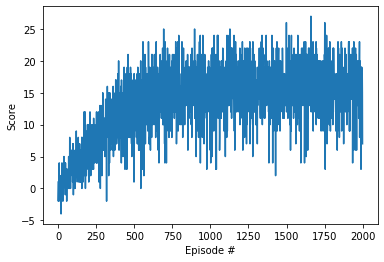

Time Taken: 1914.7703033889993


In [9]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-200000.pth', int(2e5), BATCH_SIZE, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.c Run using Buffer Size of 250,000

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 0.98
Episode 200	Average Score: 3.89
Episode 300	Average Score: 7.58
Episode 400	Average Score: 11.02
Episode 500	Average Score: 12.75
Episode 600	Average Score: 12.24
Episode 621	Average Score: 13.12
Environment solved in 621 episodes!	Average Score: 13.12
Episode 622	Average Score: 13.23
Environment solved in 622 episodes!	Average Score: 13.23
Episode 626	Average Score: 13.25
Environment solved in 626 episodes!	Average Score: 13.25
Episode 627	Average Score: 13.31
Environment solved in 627 episodes!	Average Score: 13.31
Episode 630	Average Score: 13.34
Environment solved in 630 episod

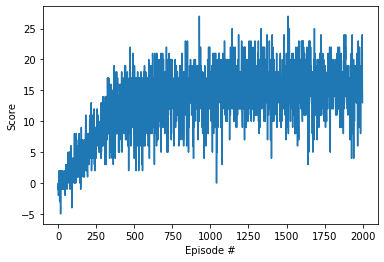

Time Taken: 1995.6891482419887


In [10]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-250000.pth', int(2.5e5), BATCH_SIZE, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.d Run using Buffer Size of 100,000 and Batch Size 32

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 1.13
Episode 200	Average Score: 5.01
Episode 300	Average Score: 7.74
Episode 400	Average Score: 9.88
Episode 491	Average Score: 13.06
Environment solved in 491 episodes!	Average Score: 13.06
Episode 495	Average Score: 13.10
Environment solved in 495 episodes!	Average Score: 13.10
Episode 496	Average Score: 13.11
Environment solved in 496 episodes!	Average Score: 13.11
Episode 498	Average Score: 13.15
Environment solved in 498 episodes!	Average Score: 13.15
Episode 500	Average Score: 13.16

Environment solved in 500 episodes!	Average Score: 13.16
Episode 501	Average Score: 13.19
Environm

Episode 1931	Average Score: 16.60
Environment solved in 1931 episodes!	Average Score: 16.60
Episode 2000	Average Score: 15.76


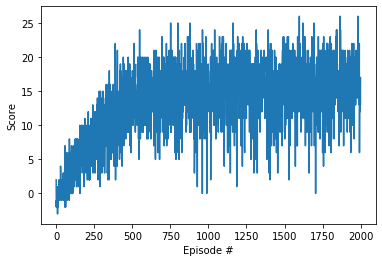

Time Taken: 1788.9697110359994


In [11]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-100000x32.pth', int(1e5), 32, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.e Run using Buffer Size of 200,000 and Batch Size 32

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 1.03
Episode 200	Average Score: 4.30
Episode 300	Average Score: 7.05
Episode 400	Average Score: 10.40
Episode 500	Average Score: 11.85
Episode 600	Average Score: 11.56
Episode 700	Average Score: 12.94
Episode 703	Average Score: 13.04
Environment solved in 703 episodes!	Average Score: 13.04
Episode 704	Average Score: 13.09
Environment solved in 704 episodes!	Average Score: 13.09
Episode 711	Average Score: 13.21
Environment solved in 711 episodes!	Average Score: 13.21
Episode 712	Average Score: 13.25
Environment solved in 712 episodes!	Average Score: 13.25
Episode 713	Average Score: 13.32

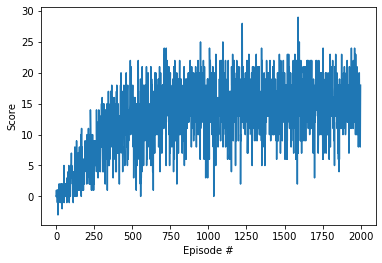

Time Taken: 1841.095480701988


In [12]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-200000x32.pth', int(2e5), 32, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.f Run using Buffer Size of 250,000 and Batch Size 32

Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 0.56
Episode 200	Average Score: 3.98
Episode 300	Average Score: 8.19
Episode 400	Average Score: 10.11
Episode 500	Average Score: 11.48
Episode 600	Average Score: 12.60
Episode 638	Average Score: 13.03
Environment solved in 638 episodes!	Average Score: 13.03
Episode 639	Average Score: 13.06
Environment solved in 639 episodes!	Average Score: 13.06
Episode 640	Average Score: 13.10
Environment solved in 640 episodes!	Average Score: 13.10
Episode 641	Average Score: 13.13
Environment solved in 641 episodes!	Average Score: 13.13
Episode 642	Average Score: 13.21
Environment solved in 642 episod

Episode 1136	Average Score: 16.43
Environment solved in 1136 episodes!	Average Score: 16.43
Episode 1200	Average Score: 15.92
Episode 1300	Average Score: 15.92
Episode 1383	Average Score: 16.45
Environment solved in 1383 episodes!	Average Score: 16.45
Episode 1400	Average Score: 15.93
Episode 1500	Average Score: 15.91
Episode 1600	Average Score: 15.72
Episode 1700	Average Score: 15.39
Episode 1800	Average Score: 15.04
Episode 1900	Average Score: 15.51
Episode 2000	Average Score: 15.65


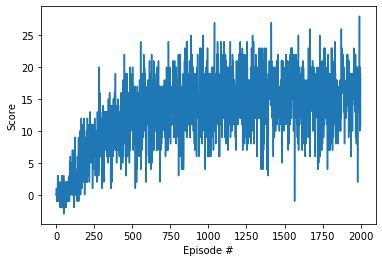

Time Taken: 1790.2813828770013


In [13]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-250000x32.pth', int(2.5e5), 32, SEED, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')